In [3]:
import string
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [39]:
# read data from the file
data = open("storyDataset.txt", encoding="utf8").read()
# preprocessing on the corpus
tokenizer = Tokenizer()
corpus = data.lower().split("\n")

In [40]:
# create a vocabulary based on list of texts
tokenizer.fit_on_texts(corpus)
# print(tokenizer.word_index)

# total words taken for processing
tot_words = len(tokenizer.word_index)+1
print( 'Total unique words: ',tot_words)


Total unique words:  3005


In [31]:
# create input sequences from the corpus
input_sequences =[]
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence=token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
for i in input_sequences:
    print(i)


Streaming output truncated to the last 5000 lines.
[18, 5]
[18, 5, 575]
[18, 5, 575, 202]
[18, 5, 575, 202, 2643]
[18, 5, 575, 202, 2643, 23]
[18, 5, 575, 202, 2643, 23, 29]
[18, 5, 575, 202, 2643, 23, 29, 1]
[18, 5, 575, 202, 2643, 23, 29, 1, 2644]
[18, 5, 575, 202, 2643, 23, 29, 1, 2644, 65]
[18, 5, 575, 202, 2643, 23, 29, 1, 2644, 65, 5]
[18, 5, 575, 202, 2643, 23, 29, 1, 2644, 65, 5, 89]
[18, 5, 575, 202, 2643, 23, 29, 1, 2644, 65, 5, 89, 397]
[2645, 9]
[2645, 9, 32]
[2645, 9, 32, 28]
[2645, 9, 32, 28, 270]
[2645, 9, 32, 28, 270, 11]
[2645, 9, 32, 28, 270, 11, 4]
[2645, 9, 32, 28, 270, 11, 4, 7]
[2645, 9, 32, 28, 270, 11, 4, 7, 17]
[2645, 9, 32, 28, 270, 11, 4, 7, 17, 496]
[2645, 9, 32, 28, 270, 11, 4, 7, 17, 496, 22]
[2645, 9, 32, 28, 270, 11, 4, 7, 17, 496, 22, 26]
[2645, 9, 32, 28, 270, 11, 4, 7, 17, 496, 22, 26, 1395]
[26, 27]
[26, 27, 15]
[26, 27, 15, 10]
[26, 27, 15, 10, 1391]
[26, 27, 15, 10, 1391, 79]
[26, 27, 15, 10, 1391, 79, 90]
[26, 27, 15, 10, 1391, 79, 90, 1]
[26, 27,

In [41]:
# pad sequences to normalize the sequences
max_sequence_len = max([len(x) for x in input_sequences])
print(max_sequence_len)

18


In [33]:
# create a numpy array for faster processing
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences.shape

(22408, 18)

In [27]:
# each words are indexed 
print(tokenizer.word_index)

{'the': 1, 'to': 2, 'and': 3, 'he': 4, 'his': 5, 'of': 6, 'was': 7, 'in': 8, 'it': 9, 'had': 10, 'that': 11, 'a': 12, 'as': 13, 'with': 14, 'gregor': 15, 'she': 16, 'not': 17, 'for': 18, 'him': 19, 'her': 20, 'would': 21, 'at': 22, 'but': 23, 'on': 24, 'they': 25, 'all': 26, 'this': 27, 'be': 28, 'from': 29, 'room': 30, 'if': 31, 'could': 32, 'you': 33, 'or': 34, 'out': 35, 'have': 36, 'there': 37, 'been': 38, 'gregor’s': 39, 'so': 40, 'father': 41, 'sister': 42, 'now': 43, 'door': 44, 'himself': 45, 'then': 46, 'back': 47, 'even': 48, 'any': 49, 'up': 50, 'mother': 51, 'into': 52, 'by': 53, 'work': 54, 'project': 55, 'did': 56, 'more': 57, 'their': 58, 'when': 59, 'about': 60, 'what': 61, 'were': 62, 'no': 63, 'them': 64, 'way': 65, 'only': 66, 'one': 67, 'time': 68, 'other': 69, 'do': 70, 'than': 71, 'i': 72, 'just': 73, 'said': 74, 'gutenbergtm': 75, 'little': 76, 'without': 77, 'get': 78, 'still': 79, 'first': 80, 'is': 81, 'see': 82, 'some': 83, 'made': 84, 'before': 85, 'go': 86,

In [35]:
# on labels one-hot-encoding is done 
X,y = input_sequences[:,:-1], input_sequences[:,-1]

# converting the data to categorical format
y= to_categorical(y, num_classes = tot_words)


In [36]:
print('Predictors : ', X.shape)
print('Labels : ', y.shape)

Predictors :  (22408, 17)
Labels :  (22408, 3034)


In [30]:
# model building
model = Sequential()
model.add(Embedding(tot_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(100))
# added to prevent overfitting
model.add(Dropout(0.2))
model.add(Dense(tot_words/2, activation='relu')) 
model.add(Dense(tot_words, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['accuracy']) 

In [31]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 100)           312900    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1564)              157964    
                                                                 
 dense_1 (Dense)             (None, 3129)              4896885   
                                                                 
Total params: 5,448,149
Trainable params: 5,448,149
Non-trainable params: 0
_________________________________________________________________
None


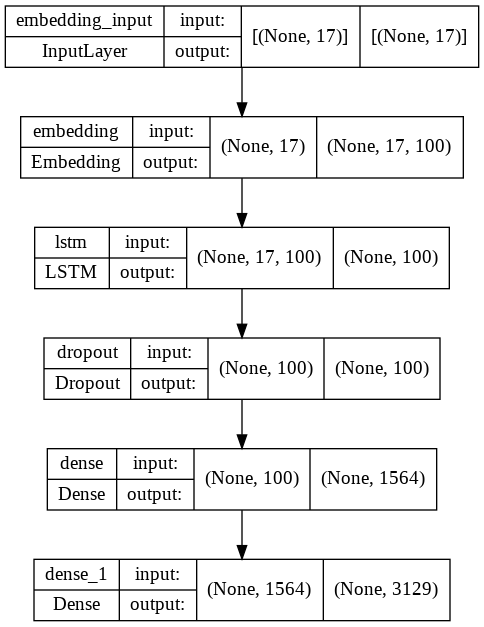

In [32]:
#Plot the build model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# model training with epochs=100
history = model.fit(X,y,epochs=100, verbose=1)

Train on 23144 samples
Epoch 1/100
23144/23144 [==============================] - 38s 2ms/sample - loss: 6.2804 - accuracy: 0.0535
Epoch 2/100
23144/23144 [==============================] - ETA: 0s - loss: 5.7250 - accuracy: 0.08 - 33s 1ms/sample - loss: 5.7251 - accuracy: 0.0864
Epoch 3/100
23144/23144 [==============================] - 32s 1ms/sample - loss: 5.2076 - accuracy: 0.1285
Epoch 4/100
23144/23144 [==============================] - 33s 1ms/sample - loss: 4.8014 - accuracy: 0.1516
Epoch 5/100
23144/23144 [==============================] - 32s 1ms/sample - loss: 4.4819 - accuracy: 0.1703
Epoch 6/100
23144/23144 [==============================] - 32s 1ms/sample - loss: 4.1842 - accuracy: 0.1899
Epoch 7/100
23144/23144 [==============================] - 32s 1ms/sample - loss: 3.8874 - accuracy: 0.2142
Epoch 8/100
23144/23144 [==============================] - 33s 1ms/sample - loss: 3.5899 - accuracy: 0.2389
Epoch 9/100
23144/23144 [==============================] - 32s 1ms/samp

In [ ]:
# open a json file and save the model which is trained
model_json = model.to_json()
with open("model_bilstm.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_bilstm.h5")
print("Saved model to disk")

Saved model to disk


In [44]:
import json
# read the json file and load the weights 
from tensorflow.keras.models import model_from_json
json_file = open('model_bilstm.json','r')
loaded_model_json= json_file.read()
json_file.close()
# fetch model from json and load load its weights
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_bilstm.h5")
print("Loaded model from disk")


Loaded model from disk


In [45]:
model = loaded_model

In [ ]:
# predict words
seed_text = "Gregor slowly pushed his"
next_word= 6
for _ in range(next_word):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list= (pad_sequences([token_list],maxlen=max_sequence_len-1, padding="pre"))
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if(index==predicted):
            output_word=word
            print('You can use next word : ',output_word)
            break
    seed_text+=(" " + output_word)
print('The complete sentence suggested: ',seed_text)

You can use next word :  way
You can use next word :  over
You can use next word :  to
You can use next word :  the
You can use next word :  door
You can use next word :  with
The complete sentence suggested:  Gregor slowly pushed his way over to the door with
